# Figure 1: Adhesome genes/loci are close in HiC

In [21]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [22]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [23]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load gene data

In [24]:
# Active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))
# Active/inactive genes
active_genes = pickle.load(open(saving_dir+'active_genes.pkl','rb'))
inactive_genes = pickle.load(open(saving_dir+'inactive_genes.pkl','rb'))

In [25]:
# Adhesome genes
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl','rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl','rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))

### Active/inactive adhesome loci per chromosome

Number of active adhesome loci = 281
Number of inactive adhesome loci = 16


<Figure size 432x288 with 0 Axes>

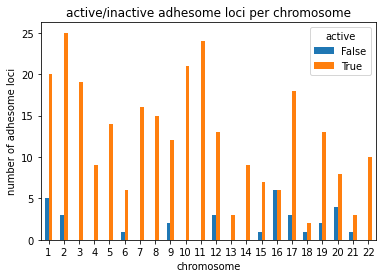

In [26]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(active_adhesome_loci)))
print('Number of inactive adhesome loci = '+str(len(inactive_adhesome_loci)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive adhesome loci per chromosome')
plt.xticks(rotation='horizontal')
plt.xlabel('chromosome')
plt.ylabel('number of adhesome loci')
plt.show()

### Compare to random loci

In [27]:
# Import list of all blacklisted loci
blacklist_list = pickle.load(open(dir_processed_hic+'blacklist_list.pkl', 'rb'))

In [28]:
# Create a dictionary of all non-blacklisted non-adhesome active for each chromosome
all_active_loci_without_adhesome = list(set(all_active_loci)-set(active_adhesome_loci)-set(blacklist_list))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}
# Create a dictionary of all non-blacklisted non-adhesome inactive for each chromosome
all_inactive_loci_without_adhesome = list(set(all_inactive_loci)-set(inactive_adhesome_loci)-set(blacklist_list))
inactive_loci_pool = {chrom: [locus for locus in all_inactive_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [29]:
# Number of adhesome loci per chromosome
number_active_adhesome_per_chrom = {chrom: len([locus for locus in active_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}
number_inactive_adhesome_per_chrom = {chrom: len([locus for locus in inactive_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [30]:
# Random non-adhesome active loci
random.seed(13)
random_active_non_adhesome_loci = list(itertools.chain.from_iterable(
    [random.sample(active_loci_pool[chrom],number_active_adhesome_per_chrom[chrom]) 
     for chrom in np.arange(1,22+1,1)]))
pickle.dump(random_active_non_adhesome_loci ,open(saving_dir+'random_active_non_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Random non-adhesome inactive loci
random.seed(13)
random_inactive_non_adhesome_loci = list(itertools.chain.from_iterable(
    [random.sample(inactive_loci_pool[chrom],number_inactive_adhesome_per_chrom[chrom]) 
     for chrom in np.arange(1,22+1,1)]))
pickle.dump(random_inactive_non_adhesome_loci ,open(saving_dir+'random_inactive_non_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# Create list out of all adhesome and random groups of loci
random_active_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb')))
random_inactive_non_adhesome_loci = np.array(pickle.load(open(saving_dir+'random_inactive_non_adhesome_loci.pkl', 'rb')))
# Group all loci list by chromosome
active_adhesome_loci = active_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in active_adhesome_loci])]
inactive_adhesome_loci = inactive_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in inactive_adhesome_loci])]
random_active_non_adhesome_loci = random_active_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_active_non_adhesome_loci])]
random_inactive_non_adhesome_loci = random_inactive_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in random_inactive_non_adhesome_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([active_adhesome_loci,
                                                inactive_adhesome_loci,
                                                random_active_non_adhesome_loci,
                                                random_inactive_non_adhesome_loci]))

In [32]:
# Compute corresponding Hi-C matrix
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df1 = contacts_df+contacts_df.T
pickle.dump(contacts_df1, open(saving_dir+'contacts_df1.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 231/231 [00:35<00:00,  6.44it/s]


In [33]:
# Compute HiC matrix for all active non-blacklisted non-adhesome loci
loci_list = all_active_loci_without_adhesome
nonadh_contacts_ls = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        nonadh_contacts_ls.append(hic_chpair_df.loc[locus1,locus2])
# Symmetrize data frame
pickle.dump(nonadh_contacts_ls, open(saving_dir+'nonadh_contacts_ls.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 231/231 [02:08<00:00,  1.79it/s]


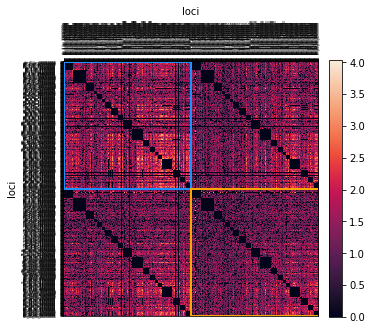

In [34]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[0,1,len(active_adhesome_loci), len(active_adhesome_loci),'dodgerblue'],
                #[0, len(active_adhesome_loci)+len(inactive_adhesome_loci),len(random_active_non_adhesome_loci),len(random_active_non_adhesome_loci),'green'],
                [len(active_adhesome_loci),len(active_adhesome_loci),len(active_adhesome_loci),len(active_adhesome_loci),'orange']]
loci_list_active = list(itertools.chain.from_iterable([active_adhesome_loci, random_active_non_adhesome_loci]))
lu.plot_heatmap(contacts_df1.loc[loci_list_active,loci_list_active],
                loci_list_active, loci_list_active, 'loci', 'loci', 
                5, contacts_df1.loc[loci_list_active,loci_list_active].max().max(), add_patches = patches_list)

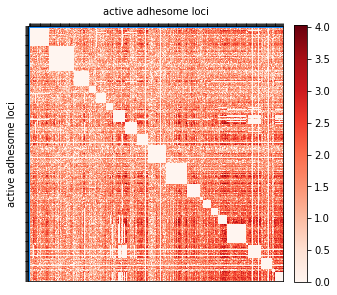

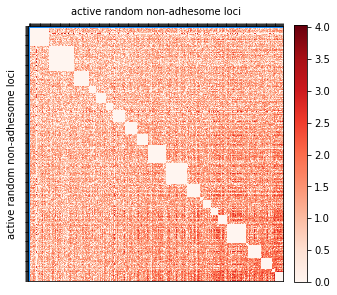

In [35]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot heatmaps
lu.plot_heatmap(contacts_df1.loc[active_adhesome_loci,active_adhesome_loci],
                ['' for _ in active_adhesome_loci], ['' for _ in active_adhesome_loci], 
                'active adhesome loci', 'active adhesome loci', 
                size=5, fontsize=5,
                vmax=contacts_df1.loc[loci_list_active,loci_list_active].max().max(), add_patches = patches_list,
                cmap='Reds')
lu.plot_heatmap(contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci],
                ['' for _ in random_active_non_adhesome_loci], ['' for _ in random_active_non_adhesome_loci], 
                'active random non-adhesome loci', 'active random non-adhesome loci', 
                size=5, fontsize=5,
                vmax=contacts_df1.loc[loci_list_active,loci_list_active].max().max(), add_patches = patches_list,
                cmap='Reds')

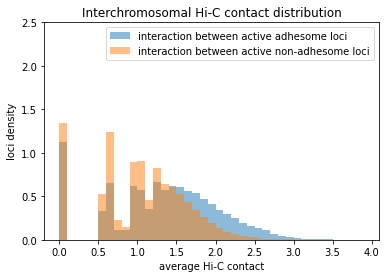

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=85.44810067044494, pvalue=0.0)


In [ ]:
# Histogram of average Hi-C contacts in three active cases

# Group of active adhesome loci with itself (remove 0 values)
# active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].sum(axis=1).values
# active_adhesome_hic_with_itself = active_adhesome_hic_with_itself/(len(active_adhesome_loci)-np.array([number_active_adhesome_per_chrom[int(l.split('_')[1])] 
#                                                                                                        for l in active_adhesome_loci]))
indices = np.triu_indices(len(contacts_df1.loc[active_adhesome_loci,active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[active_adhesome_loci,
                                                   active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of all active non-adhesome loci with itself
nonadh_contacts_ls = pickle.load(open(saving_dir+'nonadh_contacts_ls.pkl', 'rb'))
all_active_nonadhesome_hic_with_itself = nonadh_contacts_ls

# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=True, label='interaction between active adhesome loci')
plt.hist(all_active_nonadhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=True, label='interaction between active non-adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('loci density')
plt.title('Interchromosomal Hi-C contact distribution')
plt.ylim(0,2.5)
plt.legend(loc='upper right') #, bbox_to_anchor=(1,0.5)
plt.show()
# Tests

print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(active_adhesome_hic_with_itself,
                  all_active_nonadhesome_hic_with_itself))

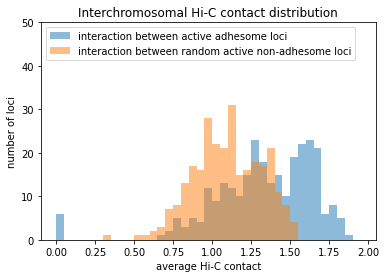

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=10.205325649588643, pvalue=1.8769046533937324e-24)
Wilcoxon Rank-Sums test (green vs orange):
RanksumsResult(statistic=1.5360593245772596, pvalue=0.12452383110604778)


In [41]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome loci with itself (remove 0 values)
#active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].mean(axis=1)
active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].sum(axis=1).values
active_adhesome_hic_with_itself = active_adhesome_hic_with_itself/(len(active_adhesome_loci)-np.array([number_active_adhesome_per_chrom[int(l.split('_')[1])] 
                                                                                                       for l in active_adhesome_loci]))
# Group of random active non-adhesome loci with itself (remove 0 values)
#random_active_adhesome_hic_with_itself = contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
random_active_adhesome_hic_with_itself = contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci].sum(axis=1).values
random_active_adhesome_hic_with_itself = random_active_adhesome_hic_with_itself/(len(random_active_non_adhesome_loci)-np.array([number_active_adhesome_per_chrom[int(l.split('_')[1])] 
                                                                                                       for l in random_active_non_adhesome_loci]))

# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = contacts_df1.loc[active_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='interaction between active adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='interaction between random active non-adhesome loci')
# plt.hist(random_versus_adhesome_active, 
#          bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Interchromosomal Hi-C contact distribution')
plt.ylim(0,50)
plt.legend(loc='upper left') #, bbox_to_anchor=(1,0.5)
plt.show()
# Tests

print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(active_adhesome_hic_with_itself,
                  random_active_adhesome_hic_with_itself))
print('Wilcoxon Rank-Sums test (green vs orange):')
print(ss.ranksums(random_versus_adhesome_active,
                  random_active_adhesome_hic_with_itself))

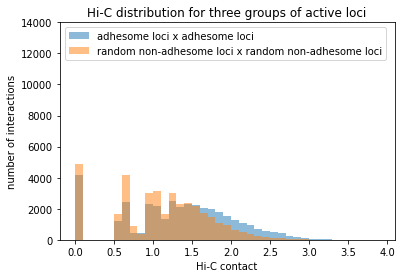

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=47.92617541820646, pvalue=0.0)


In [42]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[active_adhesome_loci,active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[active_adhesome_loci,
                                                   active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_active_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_active_non_adhesome_loci,
                                                          random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_active = sorted(contacts_df1.loc[active_adhesome_loci,
                                                 random_active_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_active_adhesome_hic_with_itself, 
         bins=np.arange(0,4,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
#plt.vlines(x=1.5, ymin=0, ymax=9000, color='red', linestyle='dashed')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,14000)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(active_adhesome_hic_with_itself,
                  random_active_adhesome_hic_with_itself))

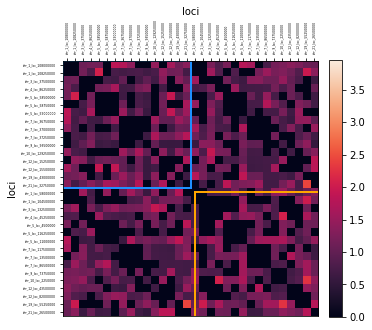

In [58]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[-0.5,-0.5,len(inactive_adhesome_loci), len(inactive_adhesome_loci),'dodgerblue'],
                [len(inactive_adhesome_loci),len(inactive_adhesome_loci),len(inactive_adhesome_loci),len(inactive_adhesome_loci),'orange']]
loci_list_inactive = list(itertools.chain.from_iterable([inactive_adhesome_loci, random_inactive_non_adhesome_loci]))
lu.plot_heatmap(contacts_df1.loc[loci_list_inactive,loci_list_inactive], 
                loci_list_inactive, loci_list_inactive, 'loci', 'loci', 
                5, contacts_df1.max().max(), add_patches = patches_list)

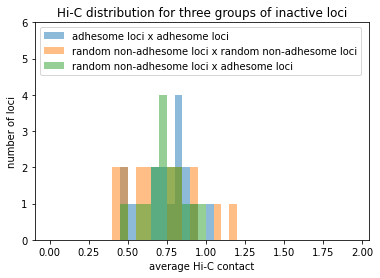

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=0.6407116072277477, pvalue=0.5217100714438103)


In [49]:
# Histogram of average Hi-C contacts in three inactive cases
# Group of inactive adhesome loci with itself
inactive_adhesome_hic_with_itself = contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = contacts_df1.loc[random_inactive_non_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Group of random inactive non-adhesome loci with inactive adhesome loci
random_versus_adhesome_inactive = contacts_df1.loc[inactive_adhesome_loci,random_inactive_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.hist(random_versus_adhesome_inactive, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='random non-adhesome loci x adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,6)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(inactive_adhesome_hic_with_itself.values,
                  random_inactive_adhesome_hic_with_itself))

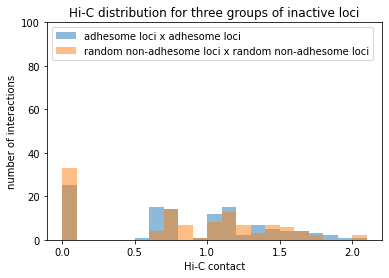

In [50]:
# Histogram of average Hi-C contacts in three active cases
indices = np.triu_indices(len(contacts_df1.loc[inactive_adhesome_loci,inactive_adhesome_loci]))
num_zeros_intraX = sum([int(number_inactive_adhesome_per_chrom[chrom]*(number_inactive_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
# Group of active adhesome loci with itself
inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[inactive_adhesome_loci,
                                                   inactive_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of random active non-adhesome loci with itself
random_inactive_adhesome_hic_with_itself = sorted(contacts_df1.loc[random_inactive_non_adhesome_loci,
                                                          random_inactive_non_adhesome_loci].values[indices])[num_zeros_intraX:]
# Histogram
plt.figure()
plt.hist(inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='adhesome loci x adhesome loci')
plt.hist(random_inactive_adhesome_hic_with_itself, 
         bins=np.arange(0,2.2,0.1), alpha=0.5, density=False, label='random non-adhesome loci x random non-adhesome loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of inactive loci')
plt.ylim(0,100)
plt.legend(loc='upper left')
plt.show()

### Supplement: show HiC connections between chromosomes

In [51]:
# Initialize empty dataframe
chr_list = np.arange(1,22+1)
chr_hic_contact = pd.DataFrame(0,index=chr_list, columns=chr_list)

In [52]:
# List all chromosome pairs
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))
    # Fill chr_hic_contact with the average Hi-C contact between chr1 and chr2
    chr_hic_contact.loc[chr1,chr2] = hic_chpair_df.mean().mean()
    chr_hic_contact.loc[chr2,chr1] = hic_chpair_df.mean().mean()

100%|██████████| 231/231 [00:03<00:00, 61.43it/s]


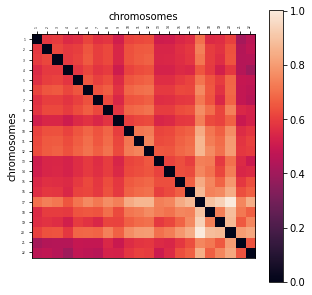

In [53]:
# Plot average HiC contact between all pairs of chromosomes
lu.plot_heatmap(chr_hic_contact, chr_list, chr_list, 'chromosomes', 'chromosomes', 
                5, chr_hic_contact.max().max())

In [103]:
# Save active/inactive adhesome genes
active_adhesome_genes_2 = df_clusters[(df_clusters['type']=='active') & (df_clusters['adhesome_gene']==1)].index.values
inactive_adhesome_genes_2 = df_clusters[(df_clusters['type']=='inactive') & (df_clusters['adhesome_gene']==1)].index.values
print('Number of active adhesome genes = '+str(len(active_adhesome_genes_2)))
print('Number of inactive adhesome genes = '+str(len(inactive_adhesome_genes_2)))
pickle.dump(active_adhesome_genes_2, open(saving_dir+'active_adhesome_genes_2.pkl','wb'))
pickle.dump(inactive_adhesome_genes_2, open(saving_dir+'inactive_adhesome_genes_2.pkl','wb'))

Number of active adhesome genes = 196
Number of inactive adhesome genes = 26
